# Load Libraries

In [72]:
# --- Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error
from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, median_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor


warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None, "display.max_columns", None)
plt.style.use('default')

# Data Wrangling

In [73]:
# --- Data Loading and Preprocessing ---
print("Loading and preprocessing the data...")
train_df = pd.read_excel('DATA/Data_Train.xlsx')
test_df = pd.read_excel('DATA/Test_set.xlsx')

Loading and preprocessing the data...


In [74]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [75]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB


In [76]:
# Data Cleaning: Handle missing values and duplicates
train_df.dropna(inplace=True)
train_df.drop_duplicates(inplace=True)
test_df.dropna(inplace=True)
test_df.drop_duplicates(inplace=True)

In [77]:
# Combine  Train and Test Dataset
df=pd.concat([train_df,test_df],ignore_index=True)
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897.0
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662.0
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218.0
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302.0


- **Price column has null values as test data does not have price column.** 

In [78]:
df.Additional_Info.value_counts()

Additional_Info
No info                         10308
In-flight meal not included      2366
No check-in baggage included      394
1 Long layover                     20
Change airports                     8
Business class                      5
No Info                             3
1 Short layover                     1
Red-eye flight                      1
2 Long layover                      1
Name: count, dtype: int64

# Pre-processing


In [79]:
# Convert string values in the 'Total_Stops' column to integer
dic = {
    'non-stop': 0,
    '1 stop': 1,
    '2 stops': 2,
    '3 stops': 3,
    '4 stops': 4
}

df['Total_Stops'] = df['Total_Stops'].map(dic)
df['Total_Stops'].value_counts()


Total_Stops
1    7052
0    4321
2    1678
3      54
4       2
Name: count, dtype: int64

In [80]:
# Convert the 'Date_of_Journey' to date format
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y')

In [81]:
# Extract the month from the 'Date_of_Journey' column and convert it to a string
df['month'] = df['Date_of_Journey'].dt.month.astype(str)
# The month is extracted as an integer, but since it represents a categorical (non-quantitative) value, we convert it to a string

# Extract the day from the 'Date_of_Journey' column and convert it to a string
df['day'] = df['Date_of_Journey'].dt.day.astype(str)
# The day is extracted as an integer, but we convert it to a string for consistency and categorical representation


In [82]:
# Extract the hours from the 'Duration' column by splitting at 'h' and taking the first part
df['Duration_hour'] = df['Duration'].str.split('h').str[0]

# Extract the minutes from the 'Duration' column by splitting at 'h', taking the second part, and removing 'm'
df['Duration_min'] = df['Duration'].str.split('h').str[1].str.replace('m', '', regex=False)

# If needed, remove any remaining characters from the right side of the 'Duration_min' values (e.g., whitespace or 'm')
df['Duration_min'] = df['Duration_min'].str.rstrip()


In [83]:
# Identify rows where 'Duration_hour' contains invalid data like '5m', which causes errors during conversion to integers
df[df['Duration_hour'] == '5m']

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,month,day,Duration_hour,Duration_min
6397,Air India,2019-03-06,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,16:50,16:55,5m,2,No info,17327.0,3,6,5m,NaN
13096,Air India,2019-03-12,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,16:50,16:55,5m,2,No info,NaN,3,12,5m,NaN


In [84]:
df.drop(df[df['Duration_hour']=='5m'].index,inplace=True)

In [85]:
# Replace and fill the empty space and 0 
df['Duration_min'].replace('', np.nan, inplace=True)
df['Duration_min'].fillna(0, inplace=True)

# Convert the 'Duration_min' column from string type to integer type for numeric operations
df['Duration_min'] = df['Duration_min'].astype(int)

In [86]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,month,day,Duration_hour,Duration_min
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897.0,3,24,2,50
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2,No info,7662.0,5,1,7,25
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2,No info,13882.0,6,9,19,0
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1,No info,6218.0,5,12,5,25
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1,No info,13302.0,3,1,4,45


In [87]:
# Convert the 'Duration_hour' column to numeric (integer) type
df['Duration_hour'] = pd.to_numeric(df['Duration_hour'], errors='coerce')

# Define the function to convert hours to minutes
def convert_to_minutes(h):
    if pd.notnull(h):  
        if h > 12:
            return (h - 12) * 60
        else:
            return h * 60
    return 0  

# Apply the conversion function
df['Duration_hour'] = df['Duration_hour'].apply(convert_to_minutes)
df['Duration_min'] = df['Duration_hour'] + df['Duration_min']

# Drop unnecessary columns
df.drop(columns=['Duration_hour', 'Duration'], inplace=True)

# Time Series Analysis

##### What is the first date of the journey?

In [88]:
df['Date_of_Journey'].max()

Timestamp('2019-06-27 00:00:00')

##### What is the last date of the journey?

In [89]:
df['Date_of_Journey'].min()

Timestamp('2019-03-01 00:00:00')

#### What are the peak hours for flight arrivals

Text(0.5, 1.0, 'Most Common Hours of Arrival Time')

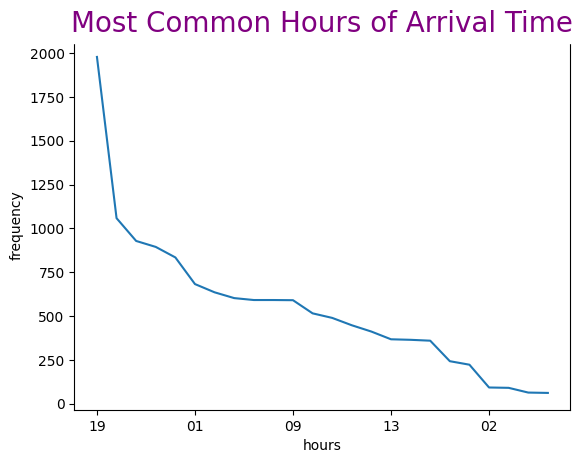

In [90]:
# Extract the hour part from the 'Arrival_Time' and calculate frequency counts
df['Arrival_Time'].str[:2].value_counts().plot(kind='line')

plt.xlabel('hours')
plt.ylabel('frequency')
plt.title("Most Common Hours of Arrival Time", 
          fontsize=20, 
          backgroundcolor='white', 
          color='purple')


- Most Flight arrives around 19 hours

#### What are the peak hours for flight departures ?

Text(0.5, 1.0, 'Most Common Hours of Departure Time')

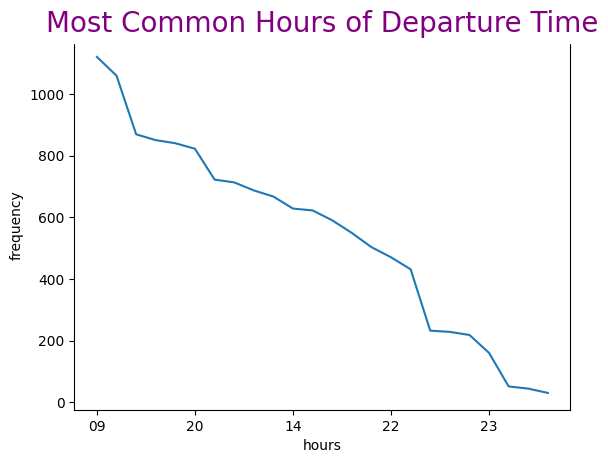

In [91]:
# Extract the hour part from the 'Dep_Time'and calculate frequency counts
df['Dep_Time'].str[:2].value_counts().plot(kind='line')
plt.xlabel('hours')
plt.ylabel('frequency')
plt.title("Most Common Hours of Departure Time", 
          fontsize=20, 
          backgroundcolor='white', 
          color='purple')

- Most flights have depature hour of 9 hours 

#### Do flight prices tend to increase or decrease at specific times of the year?

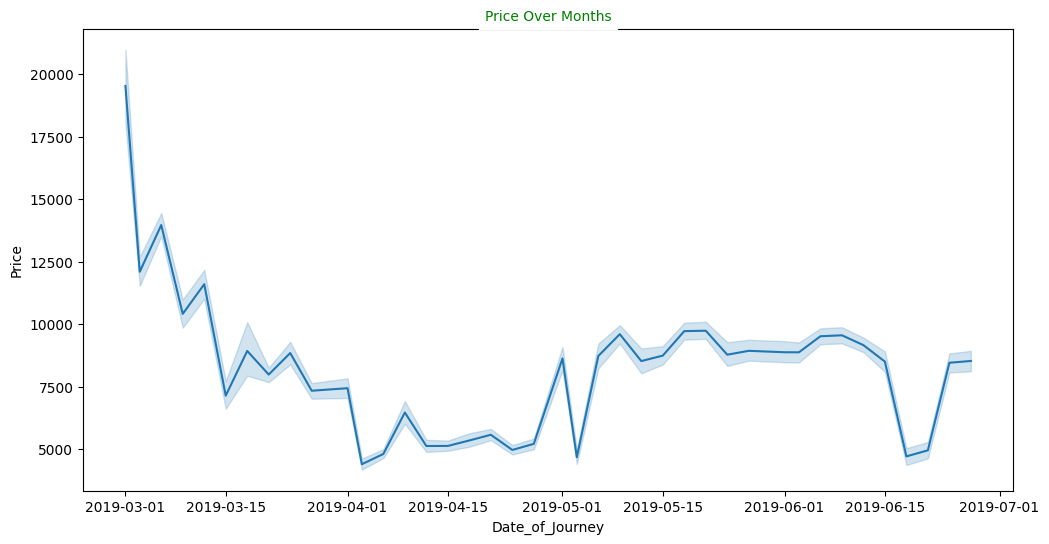

In [92]:
plt.figure(figsize=(12, 6))

sns.lineplot(x='Date_of_Journey', y='Price', data=df[df['Price'] != np.nan], palette='crest')

plt.title("Price Over Months", fontsize=10, backgroundcolor='white', color='green')

plt.show()

- Starting of the year Jan has the highest price compared throughout the year

#### Which month has the highest frequency of data entries?

[Text(0, 0, '5'), Text(1, 0, '6'), Text(2, 0, '3'), Text(3, 0, '4')]

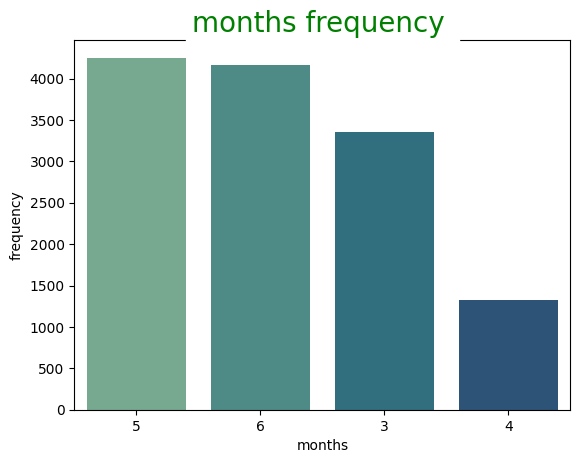

In [93]:
chart=sns.countplot(x='month',data=df,palette='crest', order = df['month'].value_counts().index)
plt.xlabel('months')
plt.ylabel('frequency')
plt.title("months frequency ",
          fontsize='20',
          backgroundcolor='white',
          color='green')
chart.set_xticklabels(chart.get_xticklabels(),rotation=360)

- The dataset has the highest number of flights recorded of the may followed by april

# What is the realtionship between the price and the journey duration?


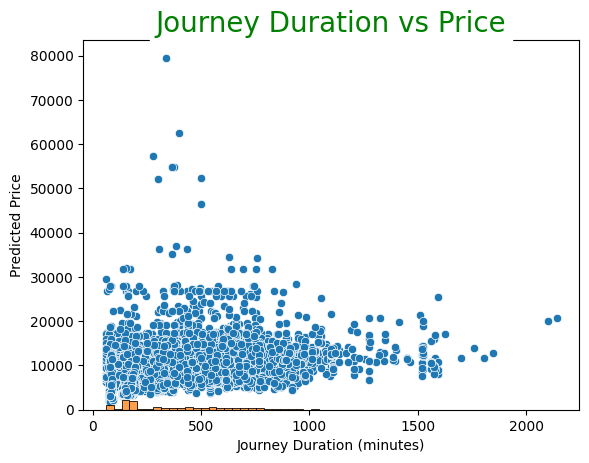

In [94]:

sns.scatterplot(x='Duration_min', y='Price', data=df)
plt.title("Journey Duration vs Price",
          fontsize=20,
          backgroundcolor='white',
          color='green')

sns.histplot(x='Duration_min', data=df, palette='crest', ax=plt.gca())
plt.xlabel("Journey Duration (minutes)")
plt.ylabel("Predicted Price")
plt.show()

Text(0.5, 1.0, 'distribution of journey minuts')

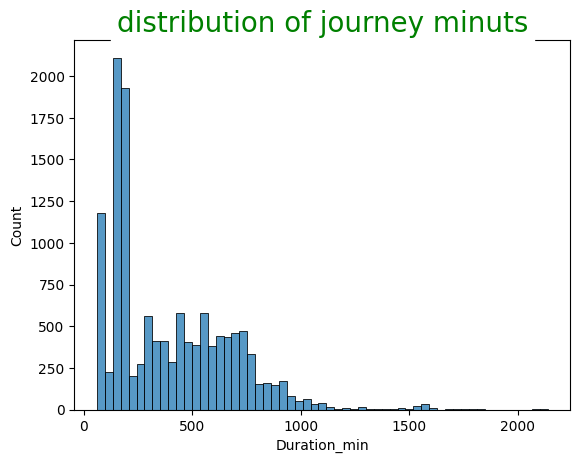

In [95]:
sns.histplot(x='Duration_min',data=df,palette='crest')
plt.title("distribution of journey minuts",
          fontsize='20',
          backgroundcolor='white',
          color='green')

- Most journeys take 500 minutes

# EDA (Exploratory Data Analysis)

#### What is the most preferred airline?

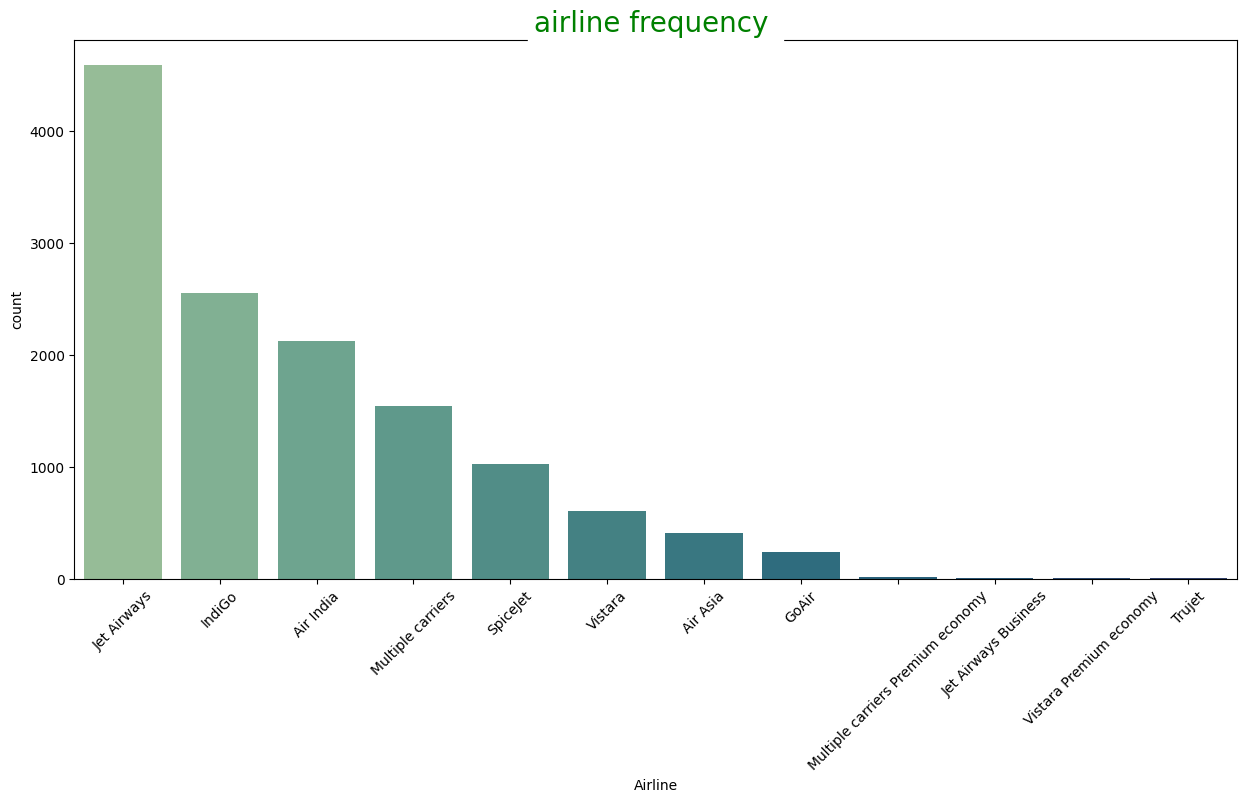

In [96]:
plt.figure(figsize=(15,7))
chart=sns.countplot(x='Airline',data=df,palette='crest', order = df['Airline'].value_counts().index)
plt.title("airline frequency ",
          fontsize='20',
          backgroundcolor='white',
          color='green')
chart.set_xticklabels(chart.get_xticklabels(),rotation=45);

- The most preferred airline is **Jet Airways** with over 4000 flights.
- The least preferred airline is **Trujet**.
- **Jet Airways** is followed by **Indigo** in terms of flight frequency.


#### Which destination city has the highest number of flights, and how does the frequency of departure(source) cities compare?

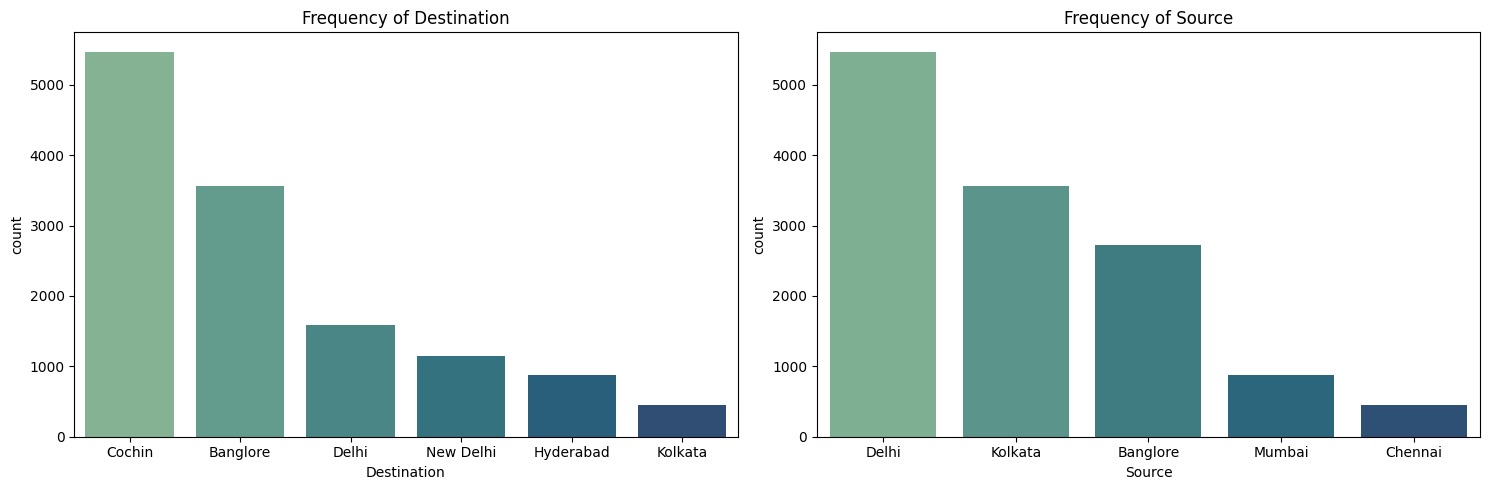

In [97]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

sns.countplot(x='Destination', data=df, palette='crest', order=df['Destination'].value_counts().index, ax=ax[0]).set(title='Frequency of Destination')
sns.countplot(x='Source', data=df, palette='crest', order=df['Source'].value_counts().index, ax=ax[1]).set(title='Frequency of Source')

plt.tight_layout()
plt.show()


- **Highest Destination City**: Cochin has the highest number of flights, with more than 5,000 flights arriving there.
- **Other Top Destination Cities**: Bangalore follows Cochin with a substantial number of flights, while Delhi, New Delhi, Hyderabad, and Kolkata have comparatively fewer flights arriving.
  
- **Highest Departure (Source) City**: Delhi has the highest number of departures, with over 5,000 flights originating from there.
- **Other Frequent Departure Cities**: Kolkata is the second most frequent source, followed by Bangalore, while Mumbai and Chennai have relatively fewer flights departing from them.

#### Are there any routes that seem disproportionately popular, with much higher frequencies compared to others?

Text(0.5, 1.0, 'most 16 routes of journeys')

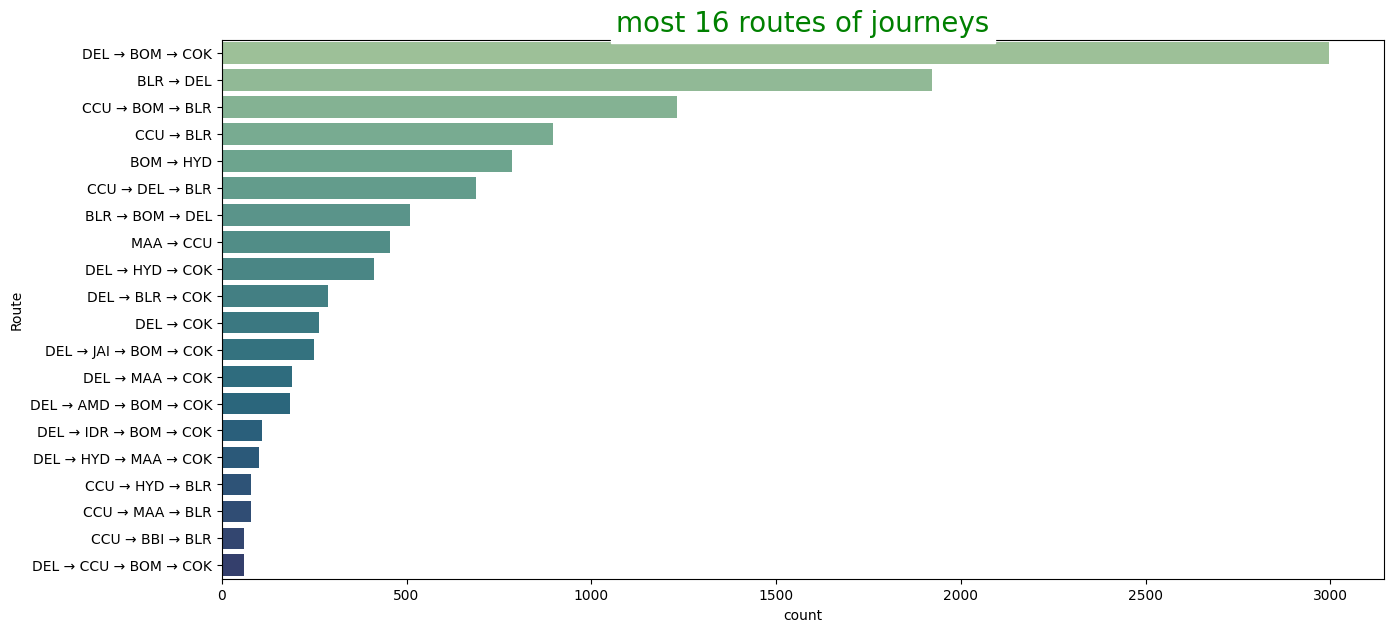

In [98]:
plt.figure(figsize=(15,7))
chart=sns.countplot(y='Route',data=df,palette='crest', order = df['Route'].value_counts()[:20].index)
plt.title("most 16 routes of journeys",
          fontsize='20',
          backgroundcolor='white',
          color='green')

 *We can see that del->bom->cok-> is the popular route with almost 1000 more frequency.*

#### What number of stops mostly taken?

Text(0.5, 1.0, 'total stops frequency ')

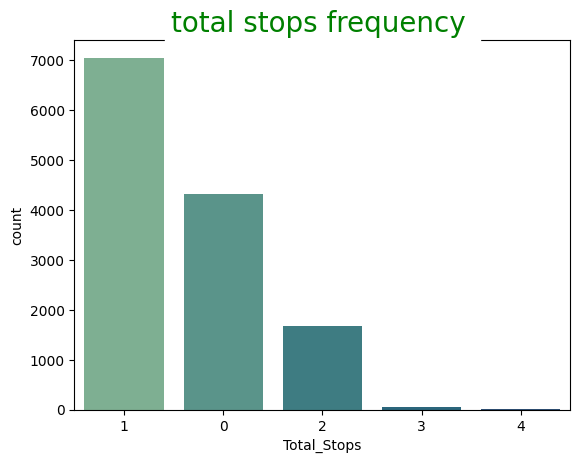

In [99]:
sns.countplot(x='Total_Stops',data=df,palette='crest', order = df['Total_Stops'].value_counts().index)
plt.title("total stops frequency ",
          fontsize='20',
          backgroundcolor='white',
          color='green')

- Most journeys take one stop during the journey

# Modeling

In [100]:
#Add column Len_Route insted of Route 
df['Len_Route']=df['Route'].apply(lambda i :len(i))
df.drop(columns=['Route'],inplace=True)

# drop columns Date_of_Journey,Dep_Time and Arrival_Time
df.drop(columns=['Date_of_Journey','Dep_Time','Arrival_Time'],axis=1,inplace=True)

In [101]:
#Convert categorical variable into dummy/indicator variables
df=pd.get_dummies(df)
df.head()

,Total_Stops,Price,Duration_min,Len_Route,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Additional_Info_1 Long layover,Additional_Info_1 Short layover,Additional_Info_2 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No Info,Additional_Info_No check-in baggage included,Additional_Info_No info,Additional_Info_Red-eye flight,month_3,month_4,month_5,month_6,day_1,day_12,day_15,day_18,day_21,day_24,day_27,day_3,day_6,day_9
0,0,3897.0,170,9,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False
1,2,7662.0,445,21,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False
2,2,13882.0,420,21,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True
3,1,6218.0,325,15,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False
4,1,13302.0,285,15,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False


In [102]:
data=df[~(df['Price'].isna())]
data.tail()

,Total_Stops,Price,Duration_min,Len_Route,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Additional_Info_1 Long layover,Additional_Info_1 Short layover,Additional_Info_2 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No Info,Additional_Info_No check-in baggage included,Additional_Info_No info,Additional_Info_Red-eye flight,month_3,month_4,month_5,month_6,day_1,day_12,day_15,day_18,day_21,day_24,day_27,day_3,day_6,day_9
10457,0,4107.0,150,9,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True
10458,0,4145.0,155,9,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
10459,0,7229.0,180,9,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
10460,0,12648.0,160,9,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False
10461,2,11753.0,500,21,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True


In [103]:
finalt_test_data=df[df['Price'].isna()]
finalt_test_data=finalt_test_data.drop(columns=['Price'])
finalt_test_data.head()

,Total_Stops,Duration_min,Len_Route,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Additional_Info_1 Long layover,Additional_Info_1 Short layover,Additional_Info_2 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No Info,Additional_Info_No check-in baggage included,Additional_Info_No info,Additional_Info_Red-eye flight,month_3,month_4,month_5,month_6,day_1,day_12,day_15,day_18,day_21,day_24,day_27,day_3,day_6,day_9
10462,1,655,15,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False
10463,1,240,15,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False
10464,1,705,15,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False
10465,1,60,15,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False
10466,0,170,9,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False


In [104]:
X=data.drop(columns=['Price'])
y=data['Price']
X.shape,y.shape

((10461, 50), (10461,))

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=24, shuffle =True)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((7322, 50), (3139, 50), (7322,), (3139,))

In [106]:
CV = []
train_scores = []
test_scores = []
models=[]

def pred_model(model,model_name, param_grid=None):
    models.append(model_name) 
    if param_grid:
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
        grid_search.fit(X_train, y_train)
        print("Best Parameters from GridSearchCV:", grid_search.best_params_)
        model = grid_search.best_estimator_ 
    
    # Training model
    model.fit(X_train, y_train)
            
    # score of train set
    train_model_score = model.score(X_train, y_train)
    train_scores.append(round(train_model_score, 2))
    y_pred_train = model.predict(X_train)
    
    # score of test set
    test_model_score = model.score(X_test, y_test)
    test_scores.append(round(test_model_score, 2))
    y_pred_test = model.predict(X_test)
    
    # train set using Cross validation
    cross_val = cross_val_score(model, X_train, y_train, cv=5)
    cv_mean = cross_val.mean()
    CV.append(round(cv_mean, 2))
    
    # Print results
    print(f"Results for {model_name}:")
    print("Train score:", round(train_model_score, 2))
    print("Test score:", round(test_model_score, 2))
    print("Train CV scores:", cross_val)
    print("Train CV mean:", round(cv_mean, 2))
    

    # Errors
    print("Mean absolute error for train:", mean_absolute_error(y_train, y_pred_train))
    print("Mean absolute error for test:", mean_absolute_error(y_test, y_pred_test))



    # Plotting Graphs
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].set_title('Residual Plot of Train samples')
    sns.histplot((y_train[:100] - y_pred_train[:100]), kde=True, ax=ax[0])
    ax[0].set_xlabel('y_train - y_pred_train')
    
    # Y_test vs Y_pred_test scatter plot
    ax[1].set_title('y_test vs y_pred_test')
    ax[1].scatter(x=y_test[:100], y=y_pred_test[:100])
    ax[1].set_xlabel('y_test')
    ax[1].set_ylabel('y_pred_test')
    plt.show()



#### Standard Linear Regression or Ordinary Least Squares

Results for LinearRegression (Tuned):
Train score: 0.72
Test score: 0.69
Train CV scores: [0.71209302 0.72947964 0.75080573 0.70044031 0.64966579]
Train CV mean: 0.71
Mean absolute error for train: 1710.779147637361
Mean absolute error for test: 1771.8386366657442


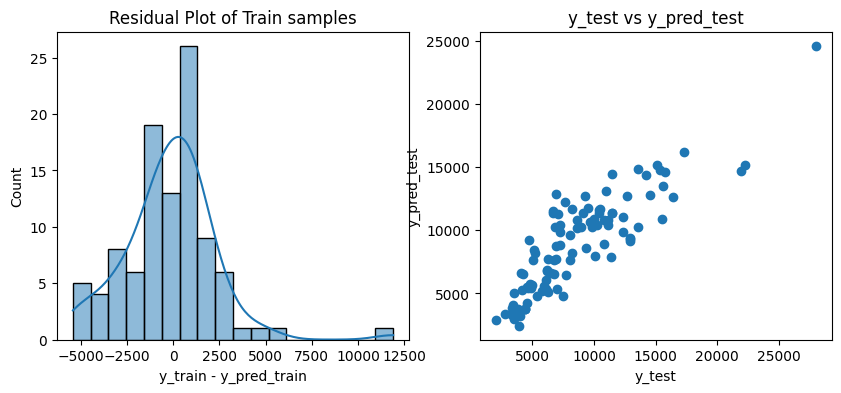

In [107]:
# Define hyperparameter grid for tuning
param_grid = {
    'fit_intercept': [True, False]
}

# Initialize the Linear Regression model
lr = LinearRegression()

# Use GridSearchCV 
grid_search = GridSearchCV(
    estimator=lr, 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_absolute_error'
)

grid_search.fit(X_train, y_train)

# Get the best estimator
best_lr = grid_search.best_estimator_

# Use the best model to make predictions with its name
pred_model(best_lr, "LinearRegression (Tuned)")


#### SGDRegressor

Results for SGDRegressor:
Train score: 0.34
Test score: 0.32
Train CV scores: [0.38626208 0.30820525 0.29799507 0.39395797 0.35523197]
Train CV mean: 0.35
Mean absolute error for train: 2448.1168040990556
Mean absolute error for test: 2560.8140926556202


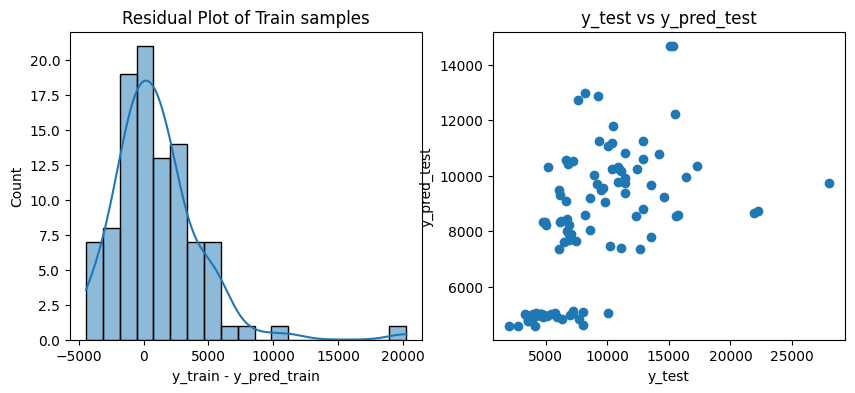

In [108]:
# Initialize SGDRegressor and define hyperparameter grid
SGDR = SGDRegressor()
param_grid = {
    "penalty": ['l2', 'l1', 'elasticnet'],
    "loss": ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
}

# Perform GridSearchCV with 5-fold cross-validation
SGDR_search = GridSearchCV(
    estimator=SGDR, 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_absolute_error'
)

# Fit the model and retrieve the best estimator
SGDR_search.fit(X_train, y_train)
best_SGDR = SGDR_search.best_estimator_

# Predict using the best model
pred_model(best_SGDR,"SGDRegressor")


In [109]:
# SGDR_rs.best_estimator_

#### Random Forest

Best Hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Results for RandomForestRegressor:
Train score: 0.93
Test score: 0.84
Train CV scores: [0.85658739 0.87668821 0.84120795 0.87595192 0.77806585]
Train CV mean: 0.85
Mean absolute error for train: 649.5554783022062
Mean absolute error for test: 956.2707576732563


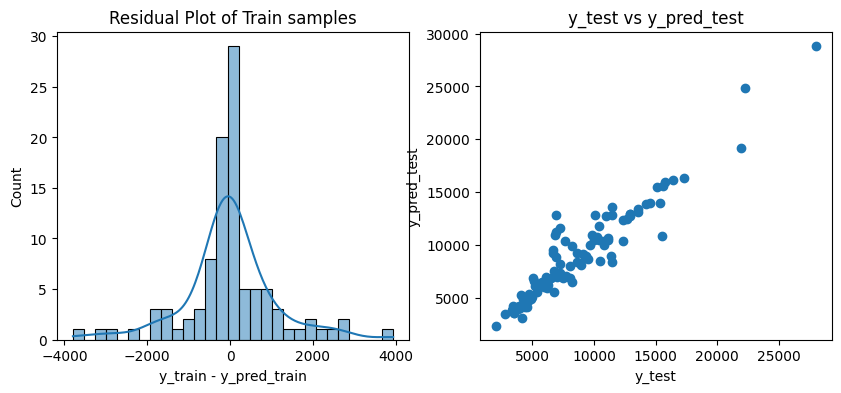

In [110]:
# Initialize RandomForestRegressor and define hyperparameter grid
RF = RandomForestRegressor()
param_grid = {
    'max_depth': [10, 20, 50, None],
    'min_samples_split': [2, 10, 20],
    'n_estimators': [50, 100, 200]
}

# Perform GridSearchCV with 5-fold cross-validation
RF_search = GridSearchCV(
    estimator=RF, 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_absolute_error'
)

# Train the model and retrieve the best estimator
RF_search.fit(X_train, y_train)
best_RF = RF_search.best_estimator_

print("Best Hyperparameters:", RF_search.best_params_)

# Predict using the best model
pred_model(best_RF,"RandomForestRegressor")


#### MLPRegressor

Best Hyperparameters: {'solver': 'adam', 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'relu'}
Results for MLPRegressor (Tuned):
Train score: 0.5
Test score: 0.48
Train CV scores: [0.49622604 0.42737907 0.39925657 0.50595791 0.46732125]
Train CV mean: 0.46
Mean absolute error for train: 2190.207941770314
Mean absolute error for test: 2325.546799472662


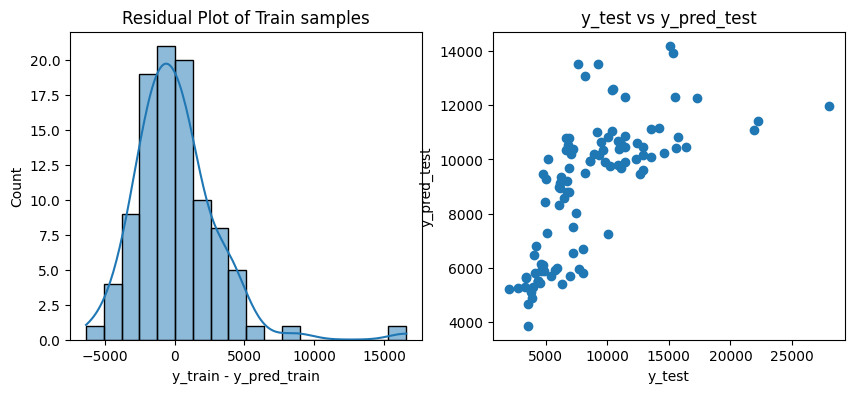

In [111]:
# Define a smaller hyperparameter space
param_grid = {
    'activation': ['relu', 'tanh'],  # Common activation functions
    'solver': ['adam'],  # Solver for weight optimization
    'hidden_layer_sizes': [(50,), (100,)],  # Simple layer configurations
    'alpha': [0.0001, 0.001]  # Regularization term
}

# Initialize MLPRegressor with early stopping
MLPR = MLPRegressor(early_stopping=True, n_iter_no_change=10, max_iter=200, random_state=42)

# Perform RandomizedSearchCV
MLPR_search = RandomizedSearchCV(
    estimator=MLPR,
    param_distributions=param_grid,
    n_iter=10,  # Number of combinations to try
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # Evaluation metric
    random_state=42
)

# Fit on a smaller subset if needed
X_train_small = X_train.sample(frac=0.5, random_state=42)  # Reduce data size to 50%
y_train_small = y_train[X_train_small.index]

# Fit RandomizedSearchCV
MLPR_search.fit(X_train_small, y_train_small)

# Retrieve the best model
best_MLPR = MLPR_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", MLPR_search.best_params_)

# Use the best estimator for prediction and evaluation
pred_model(best_MLPR, "MLPRegressor (Tuned)")



#### XGBRegressor

Best Hyperparameters: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}
Results for XGBRegressor:
Train score: 0.95
Test score: 0.84
Train CV scores: [0.86166989 0.81902102 0.87399726 0.88804128 0.78102511]
Train CV mean: 0.84
Mean absolute error for train: 572.4850468868702
Mean absolute error for test: 987.016932073996


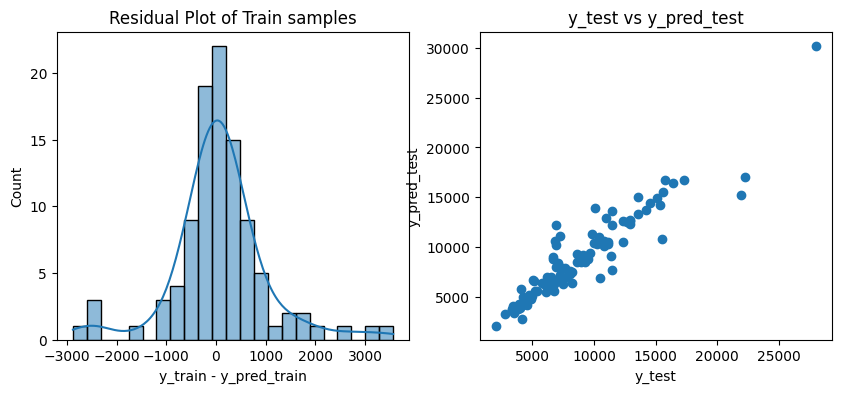

In [112]:
# Initialize XGBRegressor and define hyperparameter grid
XGBR = XGBRegressor()
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# Perform GridSearchCV with 5-fold cross-validation
XGBR_search = GridSearchCV(
    estimator=XGBR, 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_absolute_error'
)

# Train the model and retrieve the best estimator
XGBR_search.fit(X_train, y_train)
best_XGBR = XGBR_search.best_estimator_

print("Best Hyperparameters:", XGBR_search.best_params_)

# Predict using the best model
pred_model(best_XGBR,"XGBRegressor")


#### Ridge


Best Hyperparameters for Ridge: {'alpha': 0.1}
Results for Ridge:
Train score: 0.72
Test score: 0.69
Train CV scores: [0.71207102 0.72942127 0.75014253 0.70039395 0.64976781]
Train CV mean: 0.71
Mean absolute error for train: 1711.5308629470967
Mean absolute error for test: 1772.6298088469014


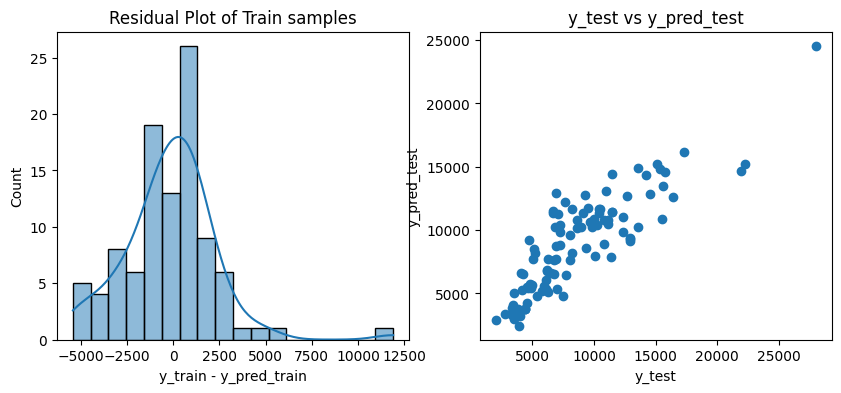

In [113]:
# Initialize Ridge model and define hyperparameter grid
ridge = Ridge()
param_grid = {'alpha': [0.1, 1, 10, 100]}

# Perform GridSearchCV with 5-fold cross-validation
ridge_search = GridSearchCV(
    estimator=ridge, 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_absolute_error'
)

# Train the model and retrieve the best estimator
ridge_search.fit(X_train, y_train)
best_ridge = ridge_search.best_estimator_

print("Best Hyperparameters for Ridge:", ridge_search.best_params_)

# Predict using the best model
pred_model(best_ridge,"Ridge")


#### Lasso


Best Hyperparameters for Lasso: {'alpha': 0.1}
Results for Lasso:
Train score: 0.72
Test score: 0.69
Train CV scores: [0.71199759 0.72567321 0.74868475 0.70036495 0.6472945 ]
Train CV mean: 0.71
Mean absolute error for train: 1711.3550610975926
Mean absolute error for test: 1770.6629189771024


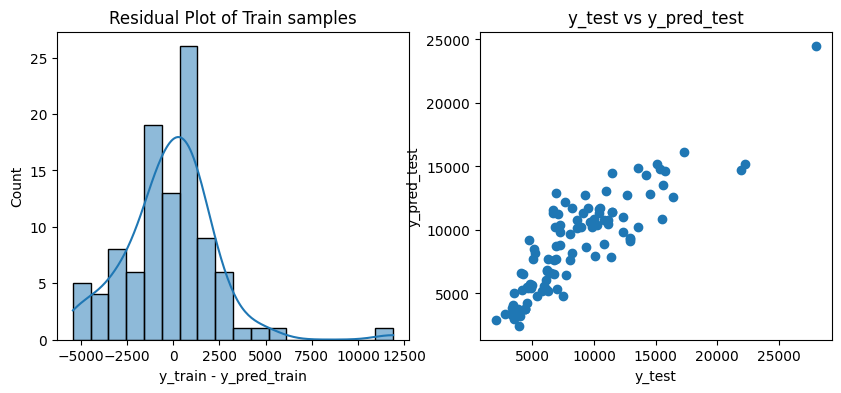

In [114]:
# Initialize Lasso model and define hyperparameter grid
lasso = Lasso()
param_grid = {'alpha': [0.1, 1, 10, 100]}

# Perform GridSearchCV with 5-fold cross-validation
lasso_search = GridSearchCV(
    estimator=lasso, 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_absolute_error'
)

# Train the model and retrieve the best estimator
lasso_search.fit(X_train, y_train)
best_lasso = lasso_search.best_estimator_

print("Best Hyperparameters for Lasso:", lasso_search.best_params_)

# Predict using the best model
pred_model(best_lasso,"Lasso")


#### K-Nearest Neighbors Regressor

Best Hyperparameters for KNeighborsRegressor: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Results for KNeighborsRegressor:
Train score: 0.98
Test score: 0.6
Train CV scores: [0.61243787 0.53659714 0.5075421  0.61319804 0.587087  ]
Train CV mean: 0.57
Mean absolute error for train: 166.3130747518893
Mean absolute error for test: 1622.2356956787385


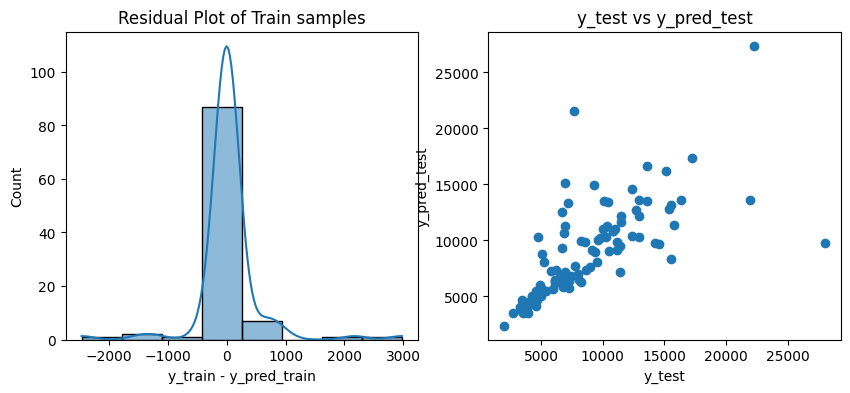

In [115]:
# Initialize KNeighborsRegressor and define hyperparameter grid
knn = KNeighborsRegressor()
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Perform GridSearchCV with 5-fold cross-validation
knn_search = GridSearchCV(
    estimator=knn, 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_absolute_error'
)

# Train the model and retrieve the best estimator
knn_search.fit(X_train, y_train)
best_knn = knn_search.best_estimator_

print("Best Hyperparameters for KNeighborsRegressor:", knn_search.best_params_)

# Predict using the best model
pred_model(best_knn,"KNeighborsRegressor")


#### Decision Tree Regressor

Best Hyperparameters for DecisionTreeRegressor: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Results for DecisionTreeRegressor:
Train score: 0.93
Test score: 0.8
Train CV scores: [0.78348101 0.82980632 0.83061737 0.8468866  0.72768895]
Train CV mean: 0.8
Mean absolute error for train: 590.5622912900022
Mean absolute error for test: 1042.590807784301


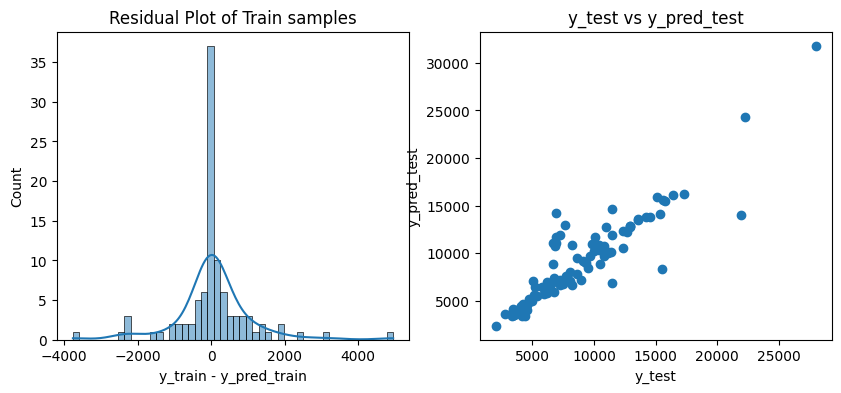

In [116]:
# Initialize DecisionTreeRegressor and define hyperparameter grid
dt = DecisionTreeRegressor()
param_grid = {
    'max_depth': [3, 5, 10, None],  
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Perform GridSearchCV with 5-fold cross-validation
dt_search = GridSearchCV(
    estimator=dt, 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_absolute_error'
)

# Train the model and retrieve the best estimator
dt_search.fit(X_train, y_train)
best_dt = dt_search.best_estimator_

print("Best Hyperparameters for DecisionTreeRegressor:", dt_search.best_params_)

# Predict using the best model
pred_model(best_dt,"DecisionTreeRegressor")


#### Gradient Boosting Regressor

Best Hyperparameters for GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Results for GradientBoostingRegressor:
Train score: 0.95
Test score: 0.85
Train CV scores: [0.84561546 0.84225376 0.86953869 0.87808698 0.77236269]
Train CV mean: 0.84
Mean absolute error for train: 618.3430709730738
Mean absolute error for test: 982.0961127372623


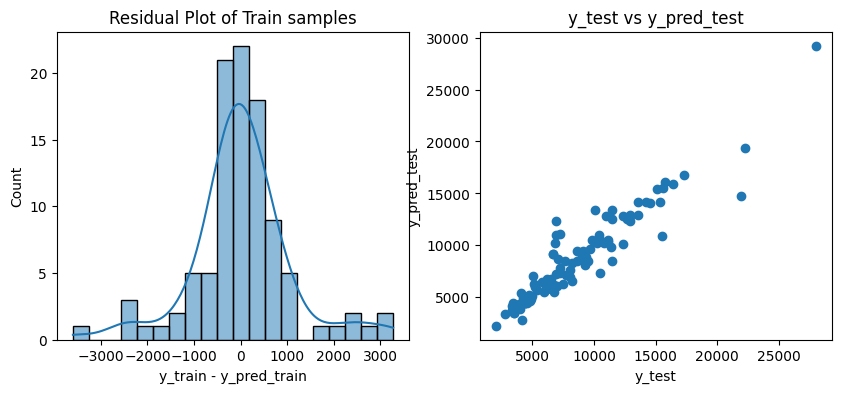

In [117]:
# Initialize GradientBoostingRegressor and define hyperparameter grid
gbr = GradientBoostingRegressor()
param_grid = {
    'n_estimators': [50, 100, 200],  
    'learning_rate': [0.01, 0.1, 0.2],  
    'max_depth': [3, 5, 7], 
    'subsample': [0.8, 1.0]
}

# Perform GridSearchCV with 5-fold cross-validation
gbr_search = GridSearchCV(
    estimator=gbr, 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_absolute_error'
)

# Train the model and retrieve the best estimator
gbr_search.fit(X_train, y_train)
best_gbr = gbr_search.best_estimator_
print("Best Hyperparameters for GradientBoostingRegressor:", gbr_search.best_params_)

# Predict using the best model
pred_model(best_gbr,"GradientBoostingRegressor")


#### RidgeCV

Best Hyperparameters for RidgeCV: {'alphas': [0.1, 1, 10, 100, 1000]}
Results for RidgeCV:
Train score: 0.72
Test score: 0.69
Train CV scores: [0.7120708  0.72942135 0.75014221 0.70039355 0.64976851]
Train CV mean: 0.71
Mean absolute error for train: 1711.538644664965
Mean absolute error for test: 1772.6321476692297


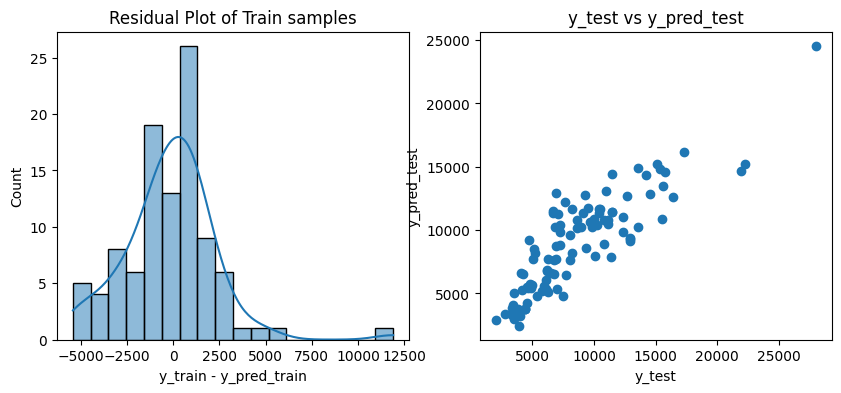

In [118]:
# Initialize RidgeCV model and define hyperparameter grid
ridgecv = RidgeCV()
param_grid = {'alphas': [[0.1, 1, 10, 100, 1000]]}

# Perform GridSearchCV with 5-fold cross-validation
ridgecv_search = GridSearchCV(
    estimator=ridgecv, 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_absolute_error'
)

# Train the model and retrieve the best estimator
ridgecv_search.fit(X_train, y_train)
best_ridgecv = ridgecv_search.best_estimator_
print("Best Hyperparameters for RidgeCV:", ridgecv_search.best_params_)

pred_model(best_ridgecv,"RidgeCV")


In [119]:
results = pd.DataFrame({
    'Model': models,
    'Train Accuracy': train_scores,
    'Test Accuracy': test_scores,
    'CV Mean Score (Train)': CV
})

display(results)

,Model,Train Accuracy,Test Accuracy,CV Mean Score (Train)
0,LinearRegression (Tuned),0.72,0.69,0.71
1,SGDRegressor,0.34,0.32,0.35
2,RandomForestRegressor,0.93,0.84,0.85
3,MLPRegressor (Tuned),0.50,0.48,0.46
4,XGBRegressor,0.95,0.84,0.84
5,Ridge,0.72,0.69,0.71
6,Lasso,0.72,0.69,0.71
7,KNeighborsRegressor,0.98,0.60,0.57
8,DecisionTreeRegressor,0.93,0.80,0.80
9,GradientBoostingRegressor,0.95,0.85,0.84


#### I will use the XGBRegressor (XGBoost) model to make predictions on the test set (final_test_data) and evaluate its performance.

# Model Interpetation (LIME )


In [120]:
# Get the best estimator from the grid search
XGBR = XGBR_search.best_estimator_


In [121]:
# LIME Explanation with Visualization
explainer = LimeTabularExplainer(
    X_train.values, 
    feature_names=X_train.columns, 
    class_names=['Price'], 
    mode='regression'
)

sample_instance = X_test.iloc[0]
explanation = explainer.explain_instance(
    sample_instance.values, 
    XGBR.predict, 
    num_features=10
)

explanation.show_in_notebook() 

**Summary Insights:**
- **Economy Class** with **1 stop** → Likely a moderate price range.
- **Not a low-cost airline** (not GoAir) → Possibly higher fare.
- **Flight in March** → Potentially higher due to spring travel demand.
- **No long layover** and **meals likely included** → More convenient, possibly increasing the price slightly.
- **Not on Monday** → Lower demand day, possibly reducing the fare.

**Overall Prediction**: The model likely predicts a moderate to slightly high price due to a mix of convenience (1 stop, no long layover) and potential seasonal demand (March).

# Final Prediction

In [122]:

# Predict on the test data
Predicted_Price = XGBR.predict(finalt_test_data)

# Display the first 5 predicted prices
print(Predicted_Price[:5])


[14214.642   4959.8677 12730.314  12982.811   3965.626 ]


In [123]:
finalt_test_data['Predicted_Price']=Predicted_Price

# Save the final dataframe with the predicted prices to a CSV file
finalt_test_data.to_csv('predicted_flight_prices.csv', index=False)


In [124]:
finalt_test_data.head()

,Total_Stops,Duration_min,Len_Route,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Additional_Info_1 Long layover,Additional_Info_1 Short layover,Additional_Info_2 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No Info,Additional_Info_No check-in baggage included,Additional_Info_No info,Additional_Info_Red-eye flight,month_3,month_4,month_5,month_6,day_1,day_12,day_15,day_18,day_21,day_24,day_27,day_3,day_6,day_9,Predicted_Price
10462,1,655,15,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,14214.641602
10463,1,240,15,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,4959.867676
10464,1,705,15,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,12730.314453
10465,1,60,15,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,12982.810547
10466,0,170,9,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,3965.625977
